<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/6205A/6205A3TempData24Hr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning goals

1. Prepare the time series data into samples.
2. We will us primitive commands to understand the sample generation steps.

In [442]:
!pip install netCDF4

In [443]:
from netCDF4 import Dataset
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [444]:
from google.colab import files
#uploaded = files.upload()

In [445]:
#drive.mount('/content/gdrive')

> The file is too big to call as raw from github or to use upload. 

Upload the file in sample_data directory from system.

In [446]:
file = '/content/sample_data/tempStJohns.nc'

# Explore the data

In [447]:
df = Dataset(file)

In [448]:
df

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-02-03 00:49:51 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data2/adaptor.mars.internal-1612306467.0641284-4955-27-685dbd6e-9572-4267-a9a7-5a61b7e919e4.nc /cache/tmp/685dbd6e-9572-4267-a9a7-5a61b7e919e4-adaptor.mars.internal-1612306467.0646257-4955-9-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(87672)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 

In [449]:
df['longitude'][0] #longitude of the place

masked_array(data=-52.75,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [450]:
df['time'] # Time series units: hours since 1900-01-01 00:00:00.0

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (87672,)
filling on, default _FillValue of -2147483647 used

In [451]:
time = df['time'][:] #start value 973008, end value 1060679

In [452]:
time

masked_array(data=[ 973008,  973009,  973010, ..., 1060677, 1060678,
                   1060679],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [453]:
time.shape

(87672,)

> Consider columns with time data

In [454]:
 df['t2m'][:,0,0,0]

masked_array(data=[272.81080791804084, 272.6567134137989,
                   272.7837285490946, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

> Convert to Celsius

In [455]:
temp = df['t2m'][:,0,0,0]-273.15

> Masked arrays are arrays that may have missing or invalid entries. The numpy.ma module provides a nearly work-alike replacement for numpy that supports data arrays with masks.



In [456]:
temp 

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

 The array is masked, filled with -32767 for the missing values, mask tells us where is that happeneing.

In [457]:
temp.data 

array([-3.39192082e-01, -4.93286586e-01, -3.66271451e-01, ...,
       -3.27670000e+04, -3.27670000e+04, -3.27670000e+04])

In [458]:
temp.shape

(87672,)

In [459]:
temp.mask

array([False, False, False, ...,  True,  True,  True])

## Rmoving masked values.

First we check if the masked values are continuous or not.

In [460]:
missing = np.where(temp.mask == True)

In [461]:
missing[0][0] # The missing data is infact continuous so our time series is not broken anywhere

86928

In [462]:
temp = temp[~temp.mask] #use the inverse of the mask as an index.

In [463]:
temp.shape # This is a continuous time series for temperature.

(86928,)

Reducing time seris to match with it

In [464]:
time = time[:86928]

In [465]:
time.shape

(86928,)

Find the unique value in numpy

In [466]:
np.unique(temp.mask) #All values are genuine now

array([False])

## Plot the temperature over time.

Plot the time series against time




In [467]:
number_of_years = (time-973008)/8760 

Temperature plot over approximately 10 years

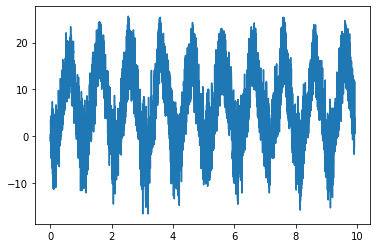

In [468]:
plt.plot(number_of_years,temp)

## Standardize the temperature

In [469]:
temp.shape

(86928,)

In [470]:
temp.mean()

5.57589982331033

In [471]:
temp.std()

7.754305350561417

(array([  297.,  2100.,  6706., 15629., 17035., 14113., 12733., 11795.,
         5601.,   919.]),
 array([-16.62485352, -12.39963379,  -8.17441406,  -3.94919434,
          0.27602539,   4.50124512,   8.72646484,  12.95168457,
         17.1769043 ,  21.40212402,  25.62734375]),
 <a list of 10 Patch objects>)

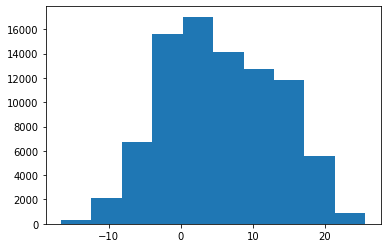

In [472]:
plt.hist(temp)

In [473]:
#temp = (temp - temp.mean())/temp.std()

In [474]:
temp.mean()

5.57589982331033

In [475]:
temp.std()

7.754305350561417

In [476]:
temp.max()

25.627343750000023

In [477]:
temp.min()

-16.624853515624977

## Generate Samples

We will avoid using functions to generate smaples to understand the process.

We want the prediction model to predict the next 6 hr of data with previous 6 hrs of temp data available.

In [478]:
temp[0:6]

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, -0.1728473870034577,
                   -0.26569093767636787, -0.4346146201507963],
             mask=[False, False, False, False, False, False],
       fill_value=-32767)

We make the vectors of size 6

In [479]:
future = 6
past = 24

In [480]:
data = []

for i in range(len(temp)- (future + past)  +1):
  data.append(temp[i:i+past].data)
data  = np.array(data) 

In [481]:
label = []
for i in range(len(temp)- (future + past)  +1):
  label.append(temp[i+ past:i+past + future].data)

label = np.array(label)


In [482]:
#no of samples
n_dataSample = len(temp)-past-future +1
print(n_dataSample)

86899


In [483]:
data.shape

(86899, 24)

In [484]:
label.shape

(86899, 6)

> Split the samples into train and test data

In [485]:
temp_train_number = np.int(0.8*len(data))

In [486]:
temp_train_number

69519

In [487]:
train_temp = data[:temp_train_number]

In [488]:
train_temp.shape

(69519, 24)

In [489]:
train_temp[temp_train_number-1]

array([-3.81502251, -3.31792267, -3.32501488, -2.65383338, -2.5977404 ,
       -2.45525134, -2.08452189, -2.08903511, -2.09096935, -1.99554682,
       -1.93300637, -1.8537025 , -1.38819526, -1.04003194, -0.77310673,
       -0.56485349, -0.4797469 , -0.47200994, -0.68284217, -0.84338414,
       -1.15157315, -1.24312721, -1.32629955, -1.44493298])

In [490]:
train_label = label[:temp_train_number]

In [491]:
train_label.shape

(69519, 6)

In [492]:
test_temp = data[temp_train_number:]

In [493]:
test_label = label[temp_train_number:]

In [494]:
print(test_label.shape)
print(test_temp.shape)

(17380, 6)
(17380, 24)


In [495]:
test_temp[1].shape

(24,)

#  Persistence Model

In [496]:
def model_persistence(test_temp_entry):
  arr = np.full((future,),test_temp_entry[past-1])

  return arr

In [497]:
test_temp[1]

array([-3.32501488, -2.65383338, -2.5977404 , -2.45525134, -2.08452189,
       -2.08903511, -2.09096935, -1.99554682, -1.93300637, -1.8537025 ,
       -1.38819526, -1.04003194, -0.77310673, -0.56485349, -0.4797469 ,
       -0.47200994, -0.68284217, -0.84338414, -1.15157315, -1.24312721,
       -1.32629955, -1.44493298, -1.40689291, -1.32952329])

In [498]:
model_persistence(test_temp[1])

array([-1.32952329, -1.32952329, -1.32952329, -1.32952329, -1.32952329,
       -1.32952329])

In [499]:
def y_persis(test_temp):
  arr = np.empty(test_label.shape)
  for i in range(len(test_temp)):
    arr[i] = model_persistence(test_temp[i])
  return arr    

In [500]:
test_temp.shape

(17380, 24)

In [501]:
y_persistence = y_persis(test_temp)

### MSE_Persistence

In [502]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [503]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_persistence))
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_persistence))

Mean squared error: 2.91
Coefficient of determination: 0.95


### Plot the temp

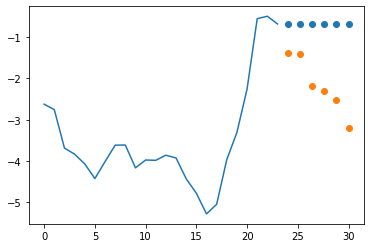

In [504]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[101])
plt.scatter(z,y_persistence[101])
plt.scatter(z,test_label[101])

# Linear regression using Sklearn

In [505]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [506]:
linear_regression = linear_model.LinearRegression()

In [507]:
linear_regression.fit(train_temp, train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [508]:
predict_label = linear_regression.predict(test_temp)

### MSE_Linear_Regression

In [509]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, predict_label))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, predict_label))

Mean squared error: 1.81
Coefficient of determination: 0.97


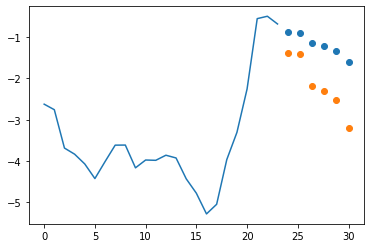

In [510]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[101])
plt.scatter(z,predict_label[101])
plt.scatter(z,test_label[101])

# Neural Network

## Normalize the data

In [511]:
train_temp_max = train_temp.max()
train_temp_min = train_temp.min()

train_temp_norm = (train_temp- train_temp_min)/(train_temp_max-train_temp_min)
test_temp_norm = (test_temp- train_temp_min)/(train_temp_max-train_temp_min)

train_label_norm = (train_label- train_temp_min)/(train_temp_max-train_temp_min)
test_label_norm = (test_label- train_temp_min)/(train_temp_max-train_temp_min)



In [512]:
train_temp.max()

25.627343750000023

In [513]:
train_label.min()

-16.624853515624977

In [514]:
#inp = tf.keras.layers.Input(shape=(6,))     # Sequential api
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
##b = tf.keras.layers.Dense(128,activation='relu')(inp)
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
#out = tf.keras.layers.Dense(6, activation='linear')(b)

#model = tf.keras.models.Model(inp,out)
#model.summary()

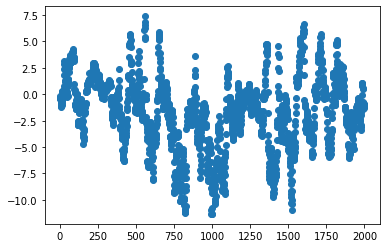

In [515]:
axis = np.linspace(0,1999,2000)
axisy = temp[0:2000]
plt.scatter(axis,axisy)

## Model

In [516]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 128)               3200      
_________________________________________________________________
dense_47 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 774       
Total params: 36,998
Trainable params: 36,998
Non-trainable params: 0
_________________________________________________________________


In [517]:
test = test_temp_norm, test_label_norm

In [518]:
hist = model.fit(train_temp_norm,train_label_norm ,batch_size=64, epochs=40,callbacks = tf.keras.callbacks.EarlyStopping(patience=5), validation_data= test)

Epoch 1/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0508 - accuracy: 0.3676 - val_loss: 0.0012 - val_mean_absolute_error: 0.0244 - val_accuracy: 0.4210
Epoch 2/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0256 - accuracy: 0.4425 - val_loss: 0.0013 - val_mean_absolute_error: 0.0274 - val_accuracy: 0.5400
Epoch 3/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0251 - accuracy: 0.4514 - val_loss: 0.0014 - val_mean_absolute_error: 0.0276 - val_accuracy: 0.4438
Epoch 4/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0245 - accuracy: 0.4583 - val_loss: 9.8138e-04 - val_mean_absolute_error: 0.0217 - val_accuracy: 0.5417
Epoch 5/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0240 - accuracy: 0.4594 - val_loss: 9.8996e-04 - val_mea

In [519]:
test_temp

array([[-3.31792267, -3.32501488, -2.65383338, ..., -1.32629955,
        -1.44493298, -1.40689291],
       [-3.32501488, -2.65383338, -2.5977404 , ..., -1.44493298,
        -1.40689291, -1.32952329],
       [-2.65383338, -2.5977404 , -2.45525134, ..., -1.40689291,
        -1.32952329, -1.26891708],
       ...,
       [ 6.44612408,  6.50479605,  6.37262294, ...,  2.18370246,
         2.84908124,  3.12825664],
       [ 6.50479605,  6.37262294,  6.03413082, ...,  2.84908124,
         3.12825664,  3.38099741],
       [ 6.37262294,  6.03413082,  4.70337326, ...,  3.12825664,
         3.38099741,  3.79363542]])

In [520]:
prediction = model.predict(test_temp_norm)

In [521]:
prediction.shape

(17380, 6)

In [522]:
test_label_norm.shape

(17380, 6)

In [523]:
model.evaluate(test_temp_norm,  test_label_norm, verbose=2)

544/544 - 0s - loss: 0.0010 - mean_absolute_error: 0.0225 - accuracy: 0.5139


[0.0010340152075514197, 0.022462662309408188, 0.5138664841651917]

## Scale back to prediction temperature

In [524]:
y_predict_norm = model.predict(test_temp_norm)

In [525]:
y_predict = train_temp_min + y_predict_norm * (train_temp_max-train_temp_min)

##MSE_Neural_Network

In [526]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict))

Mean squared error: 1.85
Coefficient of determination: 0.97


## Plot the temp

In [527]:
z = np.linspace(past, past+future,future)

In [528]:
test_temp[0]

array([-3.31792267, -3.32501488, -2.65383338, -2.5977404 , -2.45525134,
       -2.08452189, -2.08903511, -2.09096935, -1.99554682, -1.93300637,
       -1.8537025 , -1.38819526, -1.04003194, -0.77310673, -0.56485349,
       -0.4797469 , -0.47200994, -0.68284217, -0.84338414, -1.15157315,
       -1.24312721, -1.32629955, -1.44493298, -1.40689291])

In [529]:
test_label[0]

array([-1.32952329, -1.26891708, -1.02520276, -0.74860635, -0.75763281,
       -1.40044545])

In [530]:
y_predict[0]


array([-1.297081  , -1.1455364 , -1.0689325 , -1.0105438 , -0.82288074,
       -0.76502514], dtype=float32)

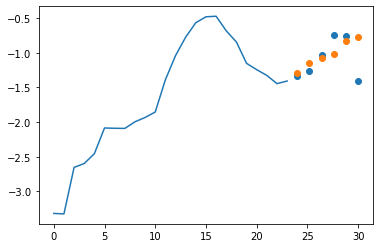

In [531]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict[0])

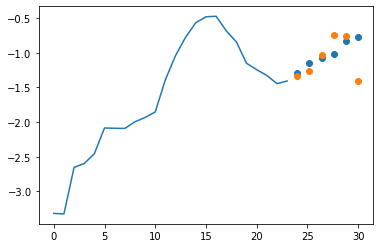

In [532]:
i = 0
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i]) # What shappeneing is that predicted values are so large in comparison to the test amd label values that is approximately starilght line

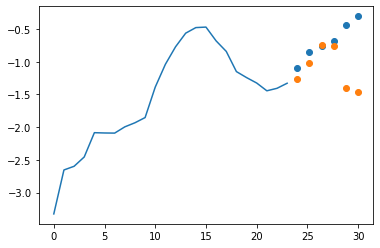

In [533]:
i = 1
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i])

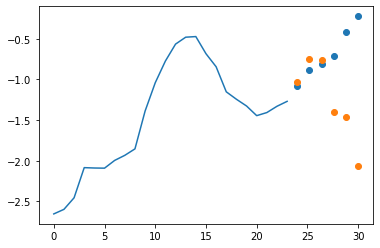

In [534]:
i = 2
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i])

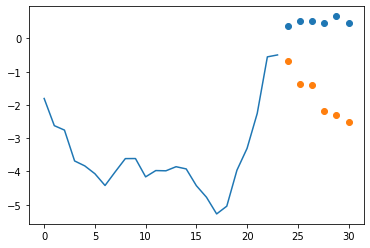

In [535]:
i = 100
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i])

# Neural Network 2

## Normalize the data

In [536]:
train_temp_max = train_temp.max()
train_temp_min = train_temp.min()

train_temp_norm = (train_temp- train_temp_min)/(train_temp_max-train_temp_min)
test_temp_norm = (test_temp- train_temp_min)/(train_temp_max-train_temp_min)

train_label_norm = (train_label- train_temp_min)/(train_temp_max-train_temp_min)
test_label_norm = (test_label- train_temp_min)/(train_temp_max-train_temp_min)



In [537]:
train_temp.max()

25.627343750000023

In [538]:
train_label.min()

-16.624853515624977

In [539]:
#inp = tf.keras.layers.Input(shape=(6,))     # Sequential api
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
##b = tf.keras.layers.Dense(128,activation='relu')(inp)
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
#out = tf.keras.layers.Dense(6, activation='linear')(b)

#model = tf.keras.models.Model(inp,out)
#model.summary()

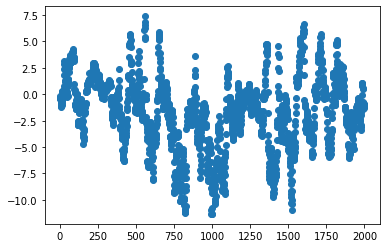

In [540]:
axis = np.linspace(0,1999,2000)
axisy = temp[0:2000]
plt.scatter(axis,axisy)

## Model

In [541]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.SGD(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 128)               3200      
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 6)                 774       
Total params: 36,998
Trainable params: 36,998
Non-trainable params: 0
_________________________________________________________________


In [542]:
test = test_temp_norm, test_label_norm

In [543]:
hist = model.fit(train_temp_norm,train_label_norm ,batch_size=64, epochs=40,callbacks = tf.keras.callbacks.EarlyStopping(patience=3), validation_data= test)

Epoch 1/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0262 - mean_absolute_error: 0.0981 - accuracy: 0.1986 - val_loss: 0.0041 - val_mean_absolute_error: 0.0500 - val_accuracy: 0.2873
Epoch 2/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0041 - mean_absolute_error: 0.0497 - accuracy: 0.2822 - val_loss: 0.0036 - val_mean_absolute_error: 0.0464 - val_accuracy: 0.2960
Epoch 3/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0463 - accuracy: 0.2908 - val_loss: 0.0033 - val_mean_absolute_error: 0.0446 - val_accuracy: 0.3082
Epoch 4/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0445 - accuracy: 0.3011 - val_loss: 0.0031 - val_mean_absolute_error: 0.0428 - val_accuracy: 0.3124
Epoch 5/40
1087/1087 [==============================] - 2s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0429 - accuracy: 0.3085 - val_loss: 0.0029 - val_mean_absolu

In [544]:
test_temp

array([[-3.31792267, -3.32501488, -2.65383338, ..., -1.32629955,
        -1.44493298, -1.40689291],
       [-3.32501488, -2.65383338, -2.5977404 , ..., -1.44493298,
        -1.40689291, -1.32952329],
       [-2.65383338, -2.5977404 , -2.45525134, ..., -1.40689291,
        -1.32952329, -1.26891708],
       ...,
       [ 6.44612408,  6.50479605,  6.37262294, ...,  2.18370246,
         2.84908124,  3.12825664],
       [ 6.50479605,  6.37262294,  6.03413082, ...,  2.84908124,
         3.12825664,  3.38099741],
       [ 6.37262294,  6.03413082,  4.70337326, ...,  3.12825664,
         3.38099741,  3.79363542]])

In [545]:
prediction = model.predict(test_temp_norm)

In [546]:
prediction.shape

(17380, 6)

In [547]:
test_label_norm.shape

(17380, 6)

In [548]:
model.evaluate(test_temp_norm,  test_label_norm, verbose=2)

544/544 - 0s - loss: 0.0014 - mean_absolute_error: 0.0274 - accuracy: 0.3970


[0.001426295260898769, 0.027414727956056595, 0.39695051312446594]

## Scale back to prediction temperature

In [549]:
y_predict_norm = model.predict(test_temp_norm)

In [550]:
y_predict2 = train_temp_min + y_predict_norm * (train_temp_max-train_temp_min)

##MSE_Neural_Network

In [551]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict2))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict2))

Mean squared error: 2.55
Coefficient of determination: 0.96


## Plot the temp

In [552]:
z = np.linspace(past, past+future,future)

In [553]:
test_temp[0]

array([-3.31792267, -3.32501488, -2.65383338, -2.5977404 , -2.45525134,
       -2.08452189, -2.08903511, -2.09096935, -1.99554682, -1.93300637,
       -1.8537025 , -1.38819526, -1.04003194, -0.77310673, -0.56485349,
       -0.4797469 , -0.47200994, -0.68284217, -0.84338414, -1.15157315,
       -1.24312721, -1.32629955, -1.44493298, -1.40689291])

In [554]:
test_label[0]

array([-1.32952329, -1.26891708, -1.02520276, -0.74860635, -0.75763281,
       -1.40044545])

In [555]:
y_predict2[0]


array([-1.6244268, -1.4390831, -1.4788523, -1.5675392, -1.410655 ,
       -1.156229 ], dtype=float32)

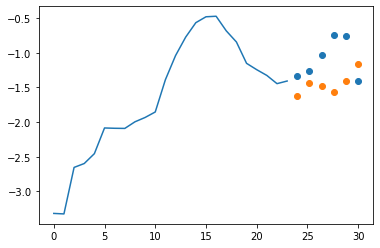

In [556]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict2[0])

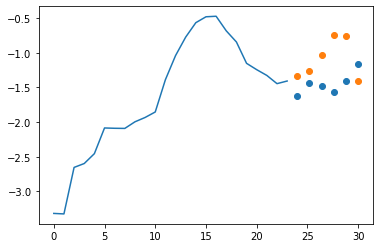

In [557]:
i = 0
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i]) # What shappeneing is that predicted values are so large in comparison to the test amd label values that is approximately starilght line

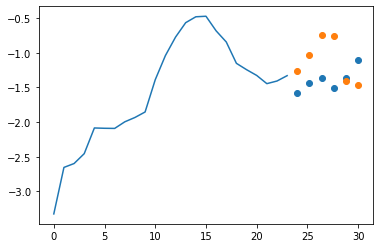

In [558]:
i = 1
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i])

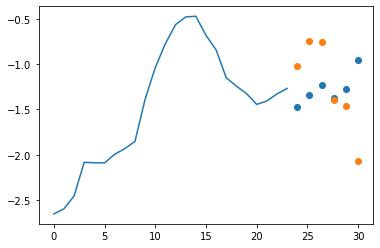

In [559]:
i = 2
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i])

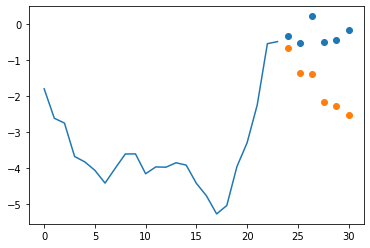

In [560]:
i = 100
plt.plot(test_temp[i])
plt.scatter(z,y_predict2[i])
plt.scatter(z,test_label[i])

# Neural Network 3

## Normalize the data

In [561]:
train_temp_max = train_temp.max()
train_temp_min = train_temp.min()

train_temp_norm = (train_temp- train_temp_min)/(train_temp_max-train_temp_min)
test_temp_norm = (test_temp- train_temp_min)/(train_temp_max-train_temp_min)

train_label_norm = (train_label- train_temp_min)/(train_temp_max-train_temp_min)
test_label_norm = (test_label- train_temp_min)/(train_temp_max-train_temp_min)



In [562]:
train_temp.max()

25.627343750000023

In [563]:
train_label.min()

-16.624853515624977

In [564]:
#inp = tf.keras.layers.Input(shape=(6,))     # Sequential api
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
##b = tf.keras.layers.Dense(128,activation='relu')(inp)
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
#out = tf.keras.layers.Dense(6, activation='linear')(b)

#model = tf.keras.models.Model(inp,out)
#model.summary()

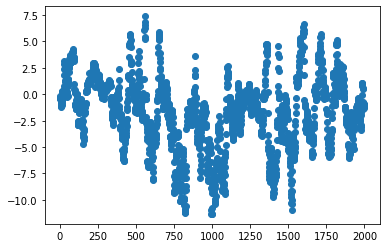

In [565]:
axis = np.linspace(0,1999,2000)
axisy = temp[0:2000]
plt.scatter(axis,axisy)

## Model

In [566]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(128,activation='tanh'),
  tf.keras.layers.Dense(128,activation='tanh'),
  tf.keras.layers.Dense(128,activation='tanh'),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 128)               3200      
_________________________________________________________________
dense_55 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_56 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_57 (Dense)             (None, 6)                 774       
Total params: 36,998
Trainable params: 36,998
Non-trainable params: 0
_________________________________________________________________


In [567]:
test = test_temp_norm, test_label_norm

In [568]:
hist = model.fit(train_temp_norm,train_label_norm ,batch_size=64, epochs=40,callbacks = tf.keras.callbacks.EarlyStopping(patience=3), validation_data= test)

Epoch 1/40
1087/1087 [==============================] - 3s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0437 - accuracy: 0.3094 - val_loss: 0.0013 - val_mean_absolute_error: 0.0265 - val_accuracy: 0.3812
Epoch 2/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0267 - accuracy: 0.3715 - val_loss: 0.0012 - val_mean_absolute_error: 0.0258 - val_accuracy: 0.1408
Epoch 3/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0256 - accuracy: 0.3884 - val_loss: 0.0011 - val_mean_absolute_error: 0.0235 - val_accuracy: 0.1979
Epoch 4/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0254 - accuracy: 0.3938 - val_loss: 0.0011 - val_mean_absolute_error: 0.0241 - val_accuracy: 0.3747
Epoch 5/40
1087/1087 [==============================] - 3s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0253 - accuracy: 0.4012 - val_loss: 0.0014 - val_mean_absolu

In [569]:
test_temp

array([[-3.31792267, -3.32501488, -2.65383338, ..., -1.32629955,
        -1.44493298, -1.40689291],
       [-3.32501488, -2.65383338, -2.5977404 , ..., -1.44493298,
        -1.40689291, -1.32952329],
       [-2.65383338, -2.5977404 , -2.45525134, ..., -1.40689291,
        -1.32952329, -1.26891708],
       ...,
       [ 6.44612408,  6.50479605,  6.37262294, ...,  2.18370246,
         2.84908124,  3.12825664],
       [ 6.50479605,  6.37262294,  6.03413082, ...,  2.84908124,
         3.12825664,  3.38099741],
       [ 6.37262294,  6.03413082,  4.70337326, ...,  3.12825664,
         3.38099741,  3.79363542]])

In [570]:
prediction = model.predict(test_temp_norm)

In [571]:
prediction.shape

(17380, 6)

In [572]:
test_label_norm.shape

(17380, 6)

In [573]:
model.evaluate(test_temp_norm,  test_label_norm, verbose=2)

544/544 - 0s - loss: 0.0011 - mean_absolute_error: 0.0233 - accuracy: 0.4111


[0.0010559597285464406, 0.0233453381806612, 0.4111047089099884]

## Scale back to prediction temperature

In [574]:
y_predict_norm = model.predict(test_temp_norm)

In [575]:
y_predict3 = train_temp_min + y_predict_norm * (train_temp_max-train_temp_min)

##MSE_Neural_Network

In [576]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict3))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict3))

Mean squared error: 1.89
Coefficient of determination: 0.97


# Regression in keras

From the perspective of linear regression errors it is very small error. We will do regression moddeling before normalzing.

In [577]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 6)                 150       
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________


In [578]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy','mse'],
)

In [579]:
hist = model.fit(train_temp,train_label, epochs=40)

Epoch 1/40
2173/2173 [==============================] - 3s 1ms/step - loss: 12.1475 - accuracy: 0.2780 - mse: 12.1475
Epoch 2/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.8926 - accuracy: 0.2802 - mse: 2.8926
Epoch 3/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.4694 - accuracy: 0.3305 - mse: 2.4694
Epoch 4/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.2957 - accuracy: 0.3629 - mse: 2.2957
Epoch 5/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.2233 - accuracy: 0.3852 - mse: 2.2233
Epoch 6/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.1933 - accuracy: 0.3923 - mse: 2.1933
Epoch 7/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.1410 - accuracy: 0.4035 - mse: 2.1410
Epoch 8/40
2173/2173 [==============================] - 2s 1ms/step - loss: 2.1415 - accuracy: 0.4096 - mse: 2.1415
Epoch 9/40
2173/2173 [==============================] - 2s 1ms/step - 

In [580]:
model.evaluate(test_temp,  test_label, verbose=2)

544/544 - 0s - loss: 1.8794 - accuracy: 0.4971 - mse: 1.8794


[1.8794293403625488, 0.497123122215271, 1.8794293403625488]

In [581]:
y_predict_LR = model.predict(test_temp)

In [582]:
y_predict_LR

array([[-1.4056246 , -1.3687255 , -1.0818669 , -1.055851  , -0.9815493 ,
        -0.839555  ],
       [-1.2894311 , -1.0161281 , -0.9301731 , -0.90663415, -0.7774509 ,
        -0.73449016],
       [-1.2419691 , -1.1573918 , -1.0797577 , -0.8920252 , -0.83276623,
        -0.77573454],
       ...,
       [ 3.427105  ,  3.5612452 ,  3.604669  ,  3.650252  ,  3.319302  ,
         3.2808146 ],
       [ 3.5878892 ,  3.6818871 ,  3.7206154 ,  3.3849058 ,  3.2775016 ,
         3.098766  ],
       [ 4.012366  ,  4.11586   ,  3.7480865 ,  3.7451737 ,  3.5866587 ,
         3.5921357 ]], dtype=float32)

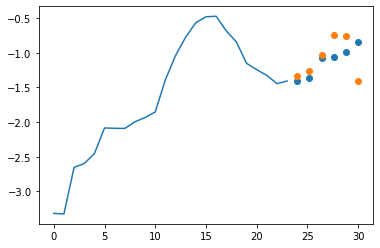

In [583]:
plt.plot(test_temp[0])
plt.scatter(z,y_predict_LR[0])
plt.scatter(z,test_label[0])

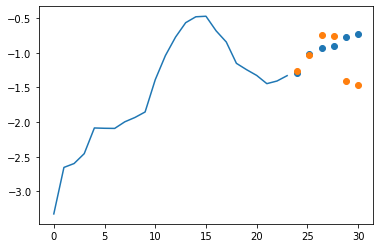

In [584]:
plt.plot(test_temp[1])
plt.scatter(z,y_predict_LR[1])
plt.scatter(z,test_label[1])

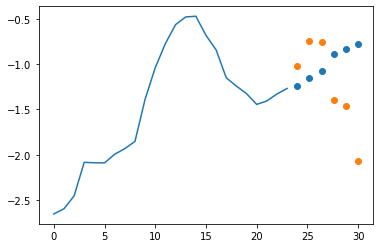

In [585]:
i = 2
plt.plot(test_temp[i])
plt.scatter(z,y_predict_LR[i])
plt.scatter(z,test_label[i])

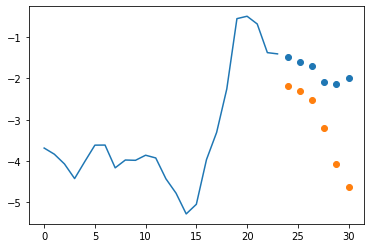

In [586]:
i = 103
plt.plot(test_temp[i])
plt.scatter(z,y_predict_LR[i])
plt.scatter(z,test_label[i])

# Model comparison


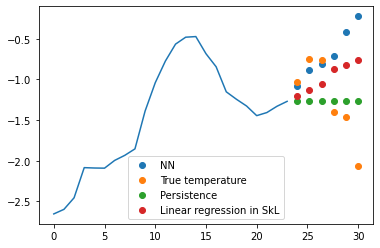

In [587]:
i = 2
z = np.linspace(past, past+future,future)
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i], label = 'NN')
plt.scatter(z,test_label[i], label = 'True temperature')
plt.scatter(z,y_persistence[i], label= 'Persistence')
plt.scatter(z,predict_label[i], label='Linear regression in SkL')
#plt.scatter(z,y_predict_LR[i], label='Linear regression in Keras')

plt.legend(loc='best')



## MSE

> We will check how MSE grows for predicted value on time axis.

In [588]:
def mse(predict):
  mse = np.ones((future,))
  for i in range(future):
     mse[i]= np.mean((test_label[:,i]-predict[:,i])**2)
  return mse 
   

In [589]:
mse(y_persistence)

array([0.35980473, 1.07395306, 2.08032862, 3.28121692, 4.64615857,
       6.03035874])

In [590]:
mse(predict_label)

array([0.22839943, 0.6234303 , 1.21430255, 1.97920815, 2.91432841,
       3.89220089])

In [591]:
mse(test_label) #test

array([0., 0., 0., 0., 0., 0.])

In [592]:
mse(y_predict) #NN

array([0.2906283 , 0.72753757, 1.25369811, 1.9439488 , 2.95131157,
       3.90871372])

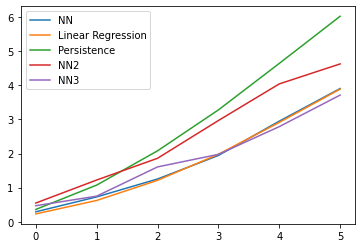

In [593]:
plt.plot(mse(y_predict), label = 'NN')
plt.plot(mse(predict_label), label = 'Linear Regression')
plt.plot(mse(y_persistence), label = 'Persistence')
plt.plot(mse(y_predict2), label = 'NN2')
plt.plot(mse(y_predict3), label = 'NN3')
plt.legend(loc='best')

# Conclusion

> We observed that for smaller values of past data, NN > Linear regression > persistence

> As we start using longer past data, we observed that NN does no better than the Linear regression, and sometimes worse.

> The feedforward NN are not very suitable to use past data effieciently as more modern architecture like RNNS
